In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import Clean Dataframe

Make sure this data does not have NaN value 

In [2]:
df = pd.read_csv('clean_car_fix.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df.isna().sum()

Make                 0
Model                0
Year                 0
Engine Fuel Type     0
Engine HP            0
Engine Cylinders     0
Transmission Type    0
Driven_Wheels        0
Number of Doors      0
Vehicle Size         0
Vehicle Style        0
highway MPG          0
city mpg             0
Popularity           0
MSRP                 0
dtype: int64

# Feature Engineering

In Some Columns there are some unusual categories that can make customers confuse. To give better understanding some values will be generalized with some familiar words. Those columns are ('Engine Fuel Type','Driven Wheels','Vehicle Style')

In [3]:
# generalize some words into familiar category
#Show Current Categorical Values
print(df['Engine Fuel Type'].value_counts())
print('====================================')
print('====================================')
print(df['Driven_Wheels'].value_counts())
print('====================================')
print('====================================')
print(df['Vehicle Style'].value_counts())
print('====================================')
print('====================================')

# Creating Function to generalize Engine Fuel Type
def SimpleFuel(x):
    if ('premium' in x['Engine Fuel Type']):
        return 'Premium'
    elif ('regular' in x['Engine Fuel Type']):
        return 'Regular'
    elif ('flex-fuel' in x['Engine Fuel Type']):
        return 'Flex-Fuel'
    elif ('diesel' in x['Engine Fuel Type']):
        return 'Diesel'
    elif ('electric' in x['Engine Fuel Type']):
        return 'Electric'
    else:
        return 'Natural Gas'

#Creating Function to generalize Driven Wheels
def SimpleWheels(x):
    if ('front' in x['Driven_Wheels']):
        return '2WD-Front'
    elif ('rear' in x['Driven_Wheels']):
        return '2WD-Rear'
    elif ('all' in x['Driven_Wheels']):
        return 'AWD'
    else:
        return '4WD'

#Creating Function to generalize Vehicle Style
def SimpleStyle(x):
    if ('Convertible SUV' in x['Vehicle Style']):
        return 'Convertible'
    elif ('SUV' in x['Vehicle Style']):
        return 'SUV'
    elif ('Convertible' in x['Vehicle Style']):
        return 'Convertible'
    elif ('Coupe' in x['Vehicle Style']):
        return 'Coupe'
    elif ('Hatchback' in x['Vehicle Style']):
        return 'Hatchback'
    elif ('Pickup' in x['Vehicle Style']):
        return 'Pickup'
    elif ('Minivan' in x['Vehicle Style']):
        return 'Minivan'
    elif ('Wagon' in x['Vehicle Style']):
        return 'Wagon'
    elif ('Van ' in x['Vehicle Style']):
        return 'Wagon'
    else:
        return 'Sedan'


regular unleaded                                7156
premium unleaded (required)                     2009
premium unleaded (recommended)                  1523
flex-fuel (unleaded/E85)                         899
diesel                                           154
electric                                          66
flex-fuel (premium unleaded required/E85)         54
flex-fuel (premium unleaded recommended/E85)      26
flex-fuel (unleaded/natural gas)                   6
natural gas                                        2
Name: Engine Fuel Type, dtype: int64
front wheel drive    4783
rear wheel drive     3358
all wheel drive      2353
four wheel drive     1401
Name: Driven_Wheels, dtype: int64
Sedan                  3047
4dr SUV                2488
Coupe                  1209
Convertible             791
4dr Hatchback           702
Crew Cab Pickup         681
Extended Cab Pickup     623
Wagon                   592
2dr Hatchback           504
Passenger Minivan       417
Regular Cab Pic

Applying those functions into each column

In [4]:
#Generalize vehicle style
df['Vehicle Style'] = df[['Vehicle Style']].apply(SimpleStyle, axis=1)
#Generalize Driven_Wheels
df['Driven_Wheels'] = df[['Driven_Wheels']].apply(SimpleWheels, axis=1)
#Generalize Engine Fuel Type
df['Engine Fuel Type'] = df[['Engine Fuel Type']].apply(SimpleFuel, axis=1)

#Show Values
print(df['Engine Fuel Type'].value_counts())
print('====================================')
print('====================================')
print(df['Driven_Wheels'].value_counts())
print('====================================')
print('====================================')
print(df['Vehicle Style'].value_counts())
print('====================================')
print('====================================')

Regular        7156
Premium        3612
Flex-Fuel       905
Diesel          154
Electric         66
Natural Gas       2
Name: Engine Fuel Type, dtype: int64
2WD-Front    4783
2WD-Rear     3358
AWD          2353
4WD          1401
Name: Driven_Wheels, dtype: int64
Sedan          3270
SUV            2622
Pickup         1688
Coupe          1209
Hatchback      1206
Convertible     820
Wagon           592
Minivan         488
Name: Vehicle Style, dtype: int64


# Modeling - From Clean Data

The model to be made is a model that has a function to predict the price of a used car. <br>

There are several algorithms that can be used to predict prices. However to streamline the experiment time, a function is created that can test these algorithms based on default modeling using Train Test Split and cross validation

In [5]:
#using Train Test Split
def regression(feature,target):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import Lasso,Ridge,LinearRegression
    from sklearn.model_selection import train_test_split
    from sklearn import metrics
    x_train, x_test, y_train, y_test = train_test_split(feature,target)
    
    algorithm = [RandomForestRegressor, Lasso, Ridge, LinearRegression]
    model =[]
    scores = []
    for item in algorithm:
        model.append(item())
    
    for item in model:
        item.fit(x_train,y_train)
        prediction = item.predict(x_test)
        mae = metrics.mean_absolute_error(y_test,prediction)
        mse = metrics.mean_squared_error(y_test,prediction)
        rmse = np.sqrt(metrics.mean_squared_error(y_test, prediction))
        temp = [mae,mse,rmse]
        scores.append(temp)
    df = pd.DataFrame(scores,columns=['MAE', 'MSE', 'RMSE'], index =['RandomForestRegressor', 'Lasso', 'Ridge', 'LinearRegression'])
    return df

In [6]:
#using cross validation
def regression_model(cv_quantity):
    from sklearn.linear_model import LinearRegression,Lasso,Ridge,LogisticRegression
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
    from sklearn.model_selection import cross_val_score,train_test_split
    from sklearn.model_selection import KFold
    from sklearn import metrics
    score = []
    model_name = ['Linear Regression','Lasso','Ridge','RandomForestRegressor']
    models = [LinearRegression,Lasso,Ridge,RandomForestRegressor]
    for item in models:
        rmse = []
        mae = []
        kf = KFold(n_splits=cv_quantity,shuffle=True)
        for train_index , test_index in kf.split(x,y):
            X_train,X_test,y_train,y_test = x.iloc[train_index],x.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
            model = item()
            model.fit(X_train,y_train)
            prediction = model.predict(X_test)
            mae.append(round(mean_absolute_error(y_test,prediction),2))
            rmse.append(round(np.sqrt(mean_squared_error(y_test,prediction)),2))

        temp = [
            sum(mae)/cv_quantity,
            sum(rmse)/cv_quantity
        ]
        score.append(temp)
    return pd.DataFrame(score,columns=['MAE','RMSE'],index=model_name)

In [7]:
#Using KFold
def regressionfold(feature,target):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.linear_model import Lasso,Ridge,LinearRegression
    from sklearn.model_selection import KFold
    from sklearn import metrics
    list_rmse = []
    list_mae = []
    list_mse = []
    
    
    algorithm = [RandomForestRegressor, Lasso, Ridge, LinearRegression]
    model =[]
    for item in algorithm:
        model.append(item())
        
    kf = KFold(n_splits=5,shuffle=True,random_state=32)
    for item in model:
        for train_index, test_index in kf.split(feature,target):
            new_mae=[]
            new_mse=[]
            new_rmse=[]
            X_test, X_train, y_test, y_train = feature.iloc[test_index] , feature.iloc[train_index] , target.iloc[test_index],target.iloc[train_index]
            item.fit(X_train,y_train)
            prediction_test = item.predict(X_test)
            new_mae.append(round(metrics.mean_absolute_error(y_test,prediction_test),2))
            new_rmse.append(round(np.sqrt(metrics.mean_squared_error(y_test,prediction_test)),2))
            new_mse.append(round(metrics.mean_squared_error(y_test,prediction_test),2))
        list_mae.append(round(sum(new_mae)/5,2))
        list_mse.append(round(sum(new_mse)/5,2))
        list_rmse.append(round(sum(new_rmse)/5,2))
    
    eval_df = pd.DataFrame({'Name' :['RandomForestRegressor', 'Lasso', 'Ridge', 'LinearRegression'] , 'MAE' : list_mae,
                               'MSE' : list_mse , 'RMSE' : list_rmse })
    
    return eval_df
    

Using One Hot Encoding

In [8]:
#Our Target
y= df['MSRP']
# Features
features_df = df.drop(['MSRP','Popularity'],axis=1)
#Change Categorical Value into Indicator Variable
x_temp1 = pd.get_dummies(features_df.drop(['Year','Engine HP','Engine Cylinders',
                                'Number of Doors','highway MPG','city mpg'],axis=1),drop_first=True)
x_temp2 = features_df[['Year','Engine HP','Engine Cylinders',
                                'Number of Doors','highway MPG','city mpg']]
x = pd.concat([x_temp1,x_temp2],axis=1)
x.head()

,Make_Alfa Romeo,Make_Aston Martin,Make_Audi,Make_BMW,Make_Bentley,Make_Bugatti,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Chrysler,...,Vehicle Style_Pickup,Vehicle Style_SUV,Vehicle Style_Sedan,Vehicle Style_Wagon,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,2011,335.0,6.0,2.0,26,19
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,2011,300.0,6.0,2.0,28,19
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,2011,300.0,6.0,2.0,28,20
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,2011,230.0,6.0,2.0,28,18
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,2011,230.0,6.0,2.0,28,18


Using Train Test Split

In [9]:
regression(x,y)

,MAE,MSE,RMSE
RandomForestRegressor,3.980966e+03,6.805377e+08,2.608712e+04
Lasso,4.290025e+03,1.835084e+08,1.354653e+04
Ridge,5.926193e+03,6.005819e+08,2.450677e+04
LinearRegression,4.744040e+09,9.686193e+21,9.841846e+10


Using Cross_val function

In [10]:
regression_model(5)

,MAE,RMSE
Linear Regression,3.716928e+09,6.652083e+10
Lasso,4.656734e+03,2.196252e+04
Ridge,5.766064e+03,1.550702e+04
RandomForestRegressor,3.527368e+03,1.420240e+04


Using kFold Function

In [11]:
regressionfold(x,y)

,Name,MAE,MSE,RMSE
0,RandomForestRegressor,648.88,11612526.72,1523.98
1,Lasso,783.85,9058847.71,1346.02
2,Ridge,1090.68,14451704.10,1700.10
3,LinearRegression,726.51,9025765.20,1343.56


Using Standard Scaler

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [13]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,Premium,335.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,Premium,300.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,Premium,300.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,Premium,230.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,Premium,230.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Convertible,28,18,3916,34500


In [14]:
scaler = StandardScaler()
df = df.reset_index(drop=True)
x_num = scaler.fit_transform(df[['Year','Engine HP','Engine Cylinders','highway MPG','city mpg']])
x_num_scaled_df = pd.DataFrame(x_num,columns=['Year','Engine HP','Engine Cylinders','highway MPG','city mpg'])
x_to_concat = df.drop(['Year','Engine HP','Engine Cylinders','highway MPG','city mpg','Popularity'],axis=1)
df_scaled = pd.concat([x_num_scaled_df ,x_to_concat.reset_index(drop=True)],axis=1)

In [15]:
x_scaled = pd.get_dummies(df_scaled.drop('MSRP', axis=1), drop_first = True)

In [16]:
y_scaled = df_scaled['MSRP']

In [17]:
regression(x_scaled, y_scaled)

,MAE,MSE,RMSE
RandomForestRegressor,3.743408e+03,1.722755e+08,1.312538e+04
Lasso,4.316718e+03,7.458250e+07,8.636116e+03
Ridge,5.959767e+03,1.629958e+08,1.276698e+04
LinearRegression,5.469889e+12,6.051420e+27,7.779087e+13


In [18]:
regressionfold(x_scaled,y_scaled)

,Name,MAE,MSE,RMSE
0,RandomForestRegressor,6.349700e+02,1.106249e+07,1.487450e+03
1,Lasso,7.835600e+02,9.057060e+06,1.345890e+03
2,Ridge,1.090340e+03,1.444393e+07,1.699640e+03
3,LinearRegression,2.000375e+10,1.156950e+24,4.810301e+11


Using PCA and standard Scaler

In [21]:
from sklearn.linear_model import LinearRegression,Lasso,Ridge,LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import KFold
from sklearn import metrics
scores = []
for item in range(1,30):
    pca = PCA(n_components=item)
    x_pca = pca.fit_transform(x_scaled)
    x_pca_df = pd.DataFrame(x_pca,columns=['PC ' + str(i) for i in range(1,item+1)])
    cv_score = cross_val_score(RandomForestRegressor(),x_pca_df,y_scaled,cv=5)
    scores.append(cv_score.mean())
data_pca_score = pd.DataFrame(scores)
data_pca_score

,0
0,0.379256
1,0.397578
2,0.549440
3,0.570829
4,0.505734
5,0.413362
6,0.397035
7,0.503618
8,0.494053
9,0.510490


In [22]:
data_pca_score[0].max()

0.6569622809516374

creating function for PCA and standard scaler based on best n_component

In [23]:
def regression_pca(x,y):
    
    pca = PCA(n_components=23)
    pca_transformer = pca.fit(x_scaled)
    x_pca18 = pca_transformer.transform(x_scaled)
    X_train, X_test, y_train, y_test = train_test_split(x_pca18,y,random_state = 101)

    algo = [RandomForestRegressor,Lasso,Ridge, LinearRegression]
    model = []
    scores = []
    for item in algo:
        model.append(item())

    for item in model:
        item.fit(X_train, y_train)
        prediction = item.predict(X_test) 
        mae = metrics.mean_absolute_error(y_test,prediction)
        mse = metrics.mean_squared_error(y_test,prediction)
        rmse = np.sqrt(metrics.mean_squared_error(y_test,prediction))
        r2_score = metrics.r2_score(y_test,prediction)
        temp = [mae,mse,rmse,r2_score]
        scores.append(temp)

    df = pd.DataFrame(scores, columns = ['MAE', 'MSE', 'RMSE','r2_score'] , index = ['RandomForestRegressor','Lasso','Ridge', 'LinearRegression'])
    return df

In [24]:
regression_pca(x_scaled,y_scaled)

,MAE,MSE,RMSE,r2_score
RandomForestRegressor,4676.629591,2.002927e+08,14152.480930,0.958286
Lasso,19098.534758,2.414703e+09,49139.632232,0.497097
Ridge,19096.508991,2.414739e+09,49139.998221,0.497090
LinearRegression,19099.971624,2.414580e+09,49138.372009,0.497123


From Those Modeling, RandomForestRegressor is choosen. Then plot the real price and the prediction using seaborn

In [25]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
x_train,x_test, y_train,y_test = train_test_split(x,y,random_state=32,test_size=0.2)
model_1 = RandomForestRegressor(random_state=32)
model_1.fit(x_train,y_train)
prediction = model_1.predict(x_test)
mae = metrics.mean_absolute_error(y_test,prediction)
mse = metrics.mean_squared_error(y_test,prediction)
rnse = np.sqrt(metrics.mean_squared_error(y_test, prediction))
print(f'Nilai MAEnya adalah {mae}')
print(f'Nilai MSEnya adalah {mse}')
print(f'Nilai RNSEnya adalah {rnse}')

Nilai MAEnya adalah 3571.2389947989586
Nilai MSEnya adalah 239708767.0592186
Nilai RNSEnya adalah 15482.531028847272


Text(0, 0.5, 'Real Price')

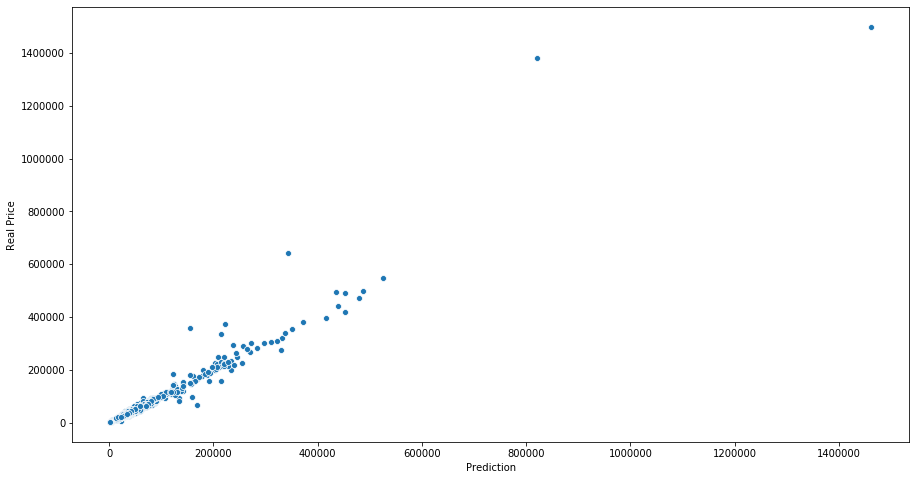

In [26]:
plt.figure(figsize=(15,8))
sns.scatterplot(prediction,y_test)
plt.xlabel('Prediction')
plt.ylabel('Real Price')

At the begining there is no process to delete outlier price. <br>
Take out outlier price from this data

# Modeling -  New Data By Removing Outlier

In [27]:
# Remove Outlier Function
def check_outlier(data, col):
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3-q1
    upper_limit = q3 + (1.5 * iqr)
    lower_limit = q1 - (1.5 * iqr)
    return data[(data[col] < lower_limit) | (data[col] > upper_limit)].index ,upper_limit,lower_limit

In [28]:
index_to_drop,upper,lower= check_outlier(df,'MSRP')
df_new = df.drop(index_to_drop)
df_new.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,Premium,335.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,Premium,300.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,Premium,300.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,Premium,230.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,Premium,230.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Convertible,28,18,3916,34500


Investigate Price Distribution

([<matplotlib.axis.XTick at 0x1b5be7dcd68>,
 <a list of 8 Text xticklabel objects>)

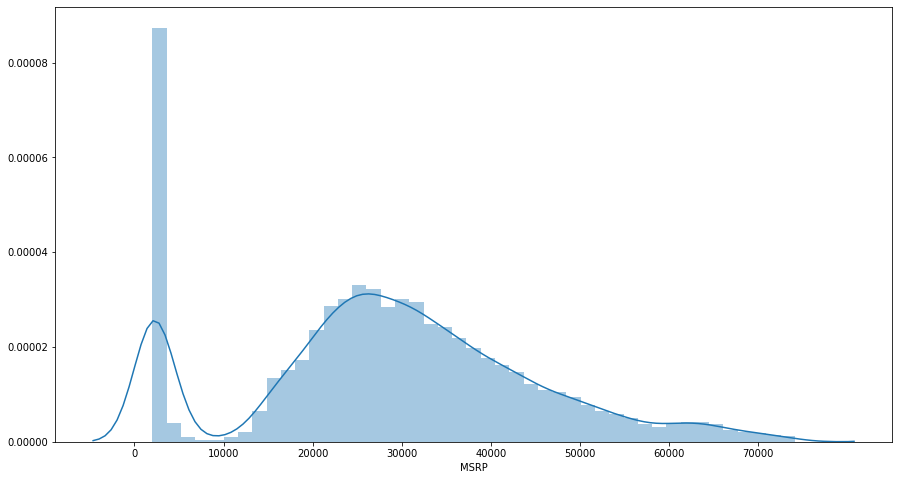

In [29]:
plt.figure(figsize=(15,8))
sns.distplot(df_new['MSRP'])
plt.xticks(np.arange(0, 80000, step=10000))

In [30]:
outlier_manual_drop = df_new[df_new['MSRP'] < 10000].index

In [31]:
df_new.drop(outlier_manual_drop,inplace=True)

In [32]:
df_new = df_new.reset_index().drop('index',axis=1)

In [33]:
#Our Target
new_y= df_new['MSRP']
# Features
new_features_df = df_new.drop(['MSRP','Popularity'],axis=1)
#Change Categorical Value into Indicator Variable
new_x_temp1 = pd.get_dummies(new_features_df.drop(['Year','Engine HP','Engine Cylinders',
                                'Number of Doors','highway MPG','city mpg'],axis=1),drop_first=True)
new_x_temp2 = new_features_df[['Year','Engine HP','Engine Cylinders',
                                'Number of Doors','highway MPG','city mpg']]
new_x = pd.concat([new_x_temp1,new_x_temp2],axis=1)
new_x.head()

,Make_Alfa Romeo,Make_Audi,Make_BMW,Make_Buick,Make_Cadillac,Make_Chevrolet,Make_Chrysler,Make_Dodge,Make_FIAT,Make_Ford,...,Vehicle Style_Pickup,Vehicle Style_SUV,Vehicle Style_Sedan,Vehicle Style_Wagon,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,2011,335.0,6.0,2.0,26,19
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,2011,300.0,6.0,2.0,28,19
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,2011,300.0,6.0,2.0,28,20
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,2011,230.0,6.0,2.0,28,18
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,2011,230.0,6.0,2.0,28,18


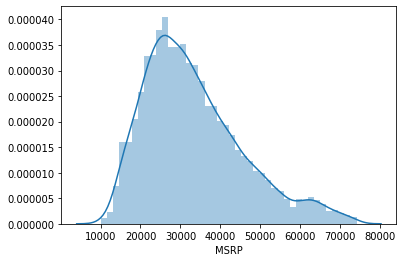

In [34]:
sns.distplot(df_new['MSRP'])

In [35]:
regression(new_x,new_y)

,MAE,MSE,RMSE
RandomForestRegressor,2.740765e+03,1.380450e+07,3.715440e+03
Lasso,2.547554e+03,1.141734e+07,3.378955e+03
Ridge,2.494819e+03,1.110603e+07,3.332571e+03
LinearRegression,1.201912e+10,3.974959e+22,1.993730e+11


In [36]:
regressionfold(new_x,new_y)

,Name,MAE,MSE,RMSE
0,RandomForestRegressor,5.313600e+02,2.685027e+06,7.328100e+02
1,Lasso,5.134200e+02,2.373850e+06,6.890400e+02
2,Ridge,5.000500e+02,2.269217e+06,6.736800e+02
3,LinearRegression,8.673965e+08,1.997201e+21,1.998600e+10


In [37]:
from sklearn.linear_model import Lasso,Ridge,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
x_train,x_test, y_train,y_test = train_test_split(new_x,new_y,random_state=99,test_size=0.2)
model_2 = RandomForestRegressor(random_state=32)
model_2.fit(x_train,y_train)
prediction = model_2.predict(x_test)
mae = metrics.mean_absolute_error(y_test,prediction)
mse = metrics.mean_squared_error(y_test,prediction)
rnse = np.sqrt(metrics.mean_squared_error(y_test, prediction))
print(f'Nilai MAEnya adalah {mae}')
print(f'Nilai MSEnya adalah {mse}')
print(f'Nilai RNSEnya adalah {rnse}')

Nilai MAEnya adalah 2702.1260813084423
Nilai MSEnya adalah 13728541.746914633
Nilai RNSEnya adalah 3705.2046835383644


Text(0, 0.5, 'Real Price')

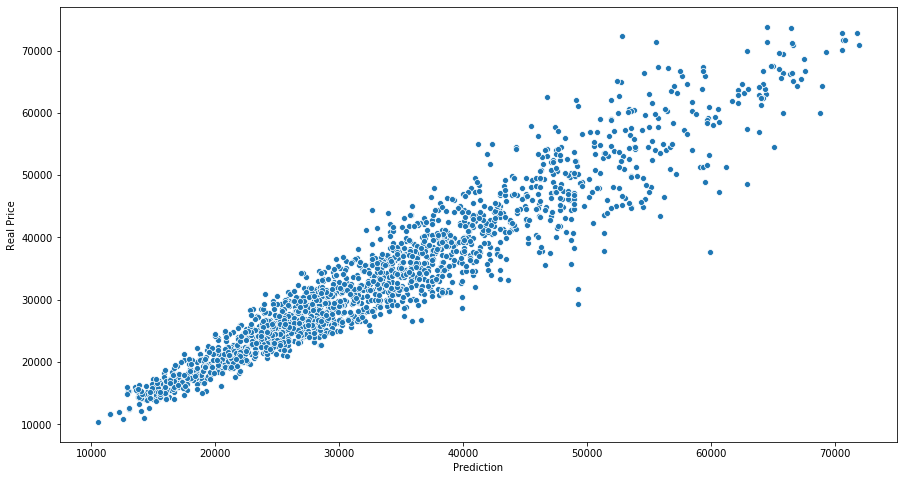

In [38]:
plt.figure(figsize=(15,8))
sns.scatterplot(prediction,y_test)
plt.xlabel('Prediction')
plt.ylabel('Real Price')

# 3rd Modeling - Simplified Model Column

Model column in this data has so many unique values. For other option, divide all unique values into 3 categories based on price. There will be 3 category. <br>
class - 3 (less than 20000 price) <br>
class - 2 (20000 - 40000) <br>
class - 1 (more than 40000)

In [39]:
def ModelSimple (x):
    if(x['MSRP'] < 20000):
        return 'Class -3'
    if((x['MSRP'] < 40000) and x['MSRP'] >= 20000):
        return 'Class -2'
    if(x['MSRP'] >= 40000):
        return 'Class -1'
df_new['Model'] = df_new[['MSRP']].apply(ModelSimple,axis=1)
df2_new = df_new.drop('Popularity',axis=1)

In [40]:
#Our Target
new_y2= df_new['MSRP']
# Features
new_features_df2 = df2_new.drop(['MSRP'],axis=1)
#Change Categorical Value into Indicator Variable
new_x2_temp1 = pd.get_dummies(new_features_df2.drop(['Year','Engine HP','Engine Cylinders',
                                'Number of Doors','highway MPG','city mpg'],axis=1),drop_first=True)
new_x2_temp2 = new_features_df2[['Year','Engine HP','Engine Cylinders',
                                'Number of Doors','highway MPG','city mpg']]
new_x2 = pd.concat([new_x2_temp1,new_x2_temp2],axis=1)

In [41]:
regression(new_x2,new_y2)

,MAE,MSE,RMSE
RandomForestRegressor,2388.217504,1.021642e+07,3196.314103
Lasso,3006.761883,1.590154e+07,3987.673657
Ridge,3006.641336,1.589443e+07,3986.782254
LinearRegression,3003.776321,1.582810e+07,3978.455000


In [42]:
regressionfold(new_x2,new_y2)

,Name,MAE,MSE,RMSE
0,RandomForestRegressor,479.87,2262454.33,672.67
1,Lasso,597.22,3207700.72,800.96
2,Ridge,597.38,3208422.78,801.05
3,LinearRegression,596.10,3193803.86,799.23


In [43]:
from sklearn.linear_model import Lasso,Ridge,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
x_train,x_test, y_train,y_test = train_test_split(new_x2,new_y2,random_state=101,test_size=0.2)
model_2 = RandomForestRegressor(random_state=32)
model_2.fit(x_train,y_train)
prediction = model_2.predict(x_test)
mae = metrics.mean_absolute_error(y_test,prediction)
mse = metrics.mean_squared_error(y_test,prediction)
rnse = np.sqrt(metrics.mean_squared_error(y_test, prediction))
print(f'Nilai MAEnya adalah {mae}')
print(f'Nilai MSEnya adalah {mse}')
print(f'Nilai RNSEnya adalah {rnse}')

Nilai MAEnya adalah 2420.505117811421
Nilai MSEnya adalah 10933229.342065886
Nilai RNSEnya adalah 3306.5434130018443


Searching for best parameter

In [44]:
from sklearn.model_selection import GridSearchCV
parameter = {'min_samples_leaf' : [1,2,3,4,5],
             'min_samples_split' : [2,3,4,5],
            'n_estimators' : [50,100,250]}
x_train,x_test, y_train,y_test = train_test_split(new_x2,new_y2,random_state=101)
grid_search_cv = GridSearchCV(RandomForestRegressor(random_state=101),parameter, cv=5)
grid_search_cv.fit(x_train,y_train)
grid_search_cv.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 250}

using hyperparam

In [45]:
from sklearn.linear_model import Lasso,Ridge,LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
x_train,x_test, y_train,y_test = train_test_split(new_x2,new_y2,random_state=101,test_size=0.2)
model_3 = RandomForestRegressor(min_samples_leaf=1, min_samples_split=5, n_estimators=250)
model_3.fit(x_train,y_train)
prediction = model_3.predict(x_test)
mae = metrics.mean_absolute_error(y_test,prediction)
mse = metrics.mean_squared_error(y_test,prediction)
rnse = np.sqrt(metrics.mean_squared_error(y_test, prediction))
percentes = (mae/(y_test.mean())*100)
print(f'Nilai MAEnya adalah {mae}')
print(f'Nilai MSEnya adalah {mse}')
print(f'Nilai RNSEnya adalah {rnse}')
print (f'Nilai percentage adalah {percentes}')

Nilai MAEnya adalah 2314.592667527988
Nilai MSEnya adalah 9964957.8072435
Nilai RNSEnya adalah 3156.7321405598386
Nilai percentage adalah 6.958315217206806


In [46]:
metrics.r2_score(y_test,prediction)

0.935731821239164

In [47]:
df2_new

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,Class -1,2011,Premium,335.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Coupe,26,19,46135
1,BMW,Class -1,2011,Premium,300.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Convertible,28,19,40650
2,BMW,Class -2,2011,Premium,300.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Coupe,28,20,36350
3,BMW,Class -2,2011,Premium,230.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Coupe,28,18,29450
4,BMW,Class -2,2011,Premium,230.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Convertible,28,18,34500
5,BMW,Class -2,2012,Premium,230.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Coupe,28,18,31200
6,BMW,Class -1,2012,Premium,300.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Convertible,26,17,44100
7,BMW,Class -2,2012,Premium,300.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Coupe,28,20,39300
8,BMW,Class -2,2012,Premium,230.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Convertible,28,18,36900
9,BMW,Class -2,2013,Premium,230.0,6.0,MANUAL,2WD-Rear,2.0,Compact,Convertible,27,18,37200


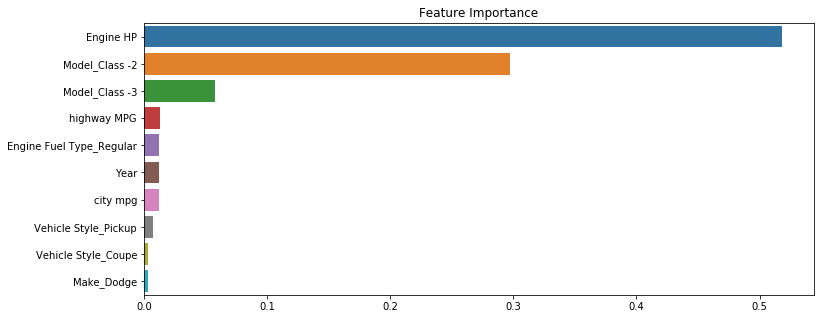

In [48]:
feat_importance = pd.Series(model_3.feature_importances_,index=new_x2.columns).sort_values(ascending=False).head(10)
plt.figure(figsize=(12,5))
plt.title('Feature Importance')
sns.barplot(x=feat_importance.values,y=feat_importance.index)

# Export Model

In [49]:
import pickle

In [50]:
filename = 'finalized_model.sav'
pickle.dump(model_3, open(filename, 'wb'))

In [51]:
filename = 'real_colomn.sav'
pickle.dump(df_new.drop('MSRP',axis=1).columns, open(filename , 'wb'))

In [52]:
filename = 'x_dummies_colomn.sav'
pickle.dump(new_x2.columns, open(filename , 'wb'))

In [53]:
df2_new.iloc[100]

Make                       BMW
Model                 Class -2
Year                      2016
Engine Fuel Type       Premium
Engine HP                  180
Engine Cylinders             4
Transmission Type    AUTOMATIC
Driven_Wheels              AWD
Number of Doors              4
Vehicle Size           Midsize
Vehicle Style            Sedan
highway MPG                 35
city mpg                    23
MSRP                     35150
Name: 100, dtype: object